In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU4.csv')

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

holidays = [
    'New Year', 'Victory over Genocide Day', 'International Women Day',
    'Khmer New Year Day 1', 'Khmer New Year Day 2', 'Khmer New Year Day 3',
    'Labour Day', 'Visak Bochea Day', 'Royal Plowing Ceremony', "King's Birthday",
    "King's Mother's Birthday", 'Constitutional Day', 'Pchum Ben Day 1',
    'Pchum Ben Day 2', "Commemoration Day of King's Father",
    "King's Coronation Day", 'Independence Day', 'Water Festival Day 1',
    'Water Festival Day 2', 'Water Festival Day 3', 'Chrismas'
]

promotions = [
    'Discount Promotion', 'Loyalty Program Promotion',
    'Bundle Promotion', 'Flash Sale Promotion'
]

for dataset in [df]:
    dataset['holiday_type'] = dataset[holidays].idxmax(axis=1).where(dataset[holidays].any(axis=1), 'None')
    dataset['promotion_type'] = dataset[promotions].idxmax(axis=1).where(dataset[promotions].any(axis=1), 'None')

train_size = int(len(df) * 0.70)
val_size = int(len(df) * 0.15)

train = df.iloc[:train_size].copy()
val = df.iloc[train_size:train_size + val_size].copy()
test = df.iloc[train_size + val_size:].copy()



In [3]:
for dataset in [train, val, test]:
    dataset['month'] = dataset.index.month
    dataset['day_of_week'] = dataset.index.dayofweek
    dataset['month_sin'] = np.sin(2 * np.pi * dataset['month'] / 12)
    dataset['month_cos'] = np.cos(2 * np.pi * dataset['month'] / 12)
    dataset['day_sin'] = np.sin(2 * np.pi * dataset['day_of_week'] / 7)
    dataset['day_cos'] = np.cos(2 * np.pi * dataset['day_of_week'] / 7)

train = pd.get_dummies(train, columns=['holiday_type', 'promotion_type'])
val = pd.get_dummies(val, columns=['holiday_type', 'promotion_type'])
test = pd.get_dummies(test, columns=['holiday_type', 'promotion_type'])

In [4]:
all_columns = set(train.columns) | set(val.columns) | set(test.columns)
for dataset in [train, val, test]:
    missing_columns = all_columns - set(dataset.columns)
    for column in missing_columns:
        dataset[column] = 0

train = train[sorted(train.columns)]
val = val[sorted(val.columns)]
test = test[sorted(test.columns)]

def add_rolling_and_lag_features(dataset):
    dataset['rolling_mean_7'] = dataset['sales'].rolling(window=7).mean().shift(1, fill_value=0)
    dataset['rolling_mean_30'] = dataset['sales'].rolling(window=30).mean().shift(1, fill_value=0)
    dataset['lag_7'] = dataset['sales'].shift(7, fill_value=0)
    dataset['lag_30'] = dataset['sales'].shift(30, fill_value=0)
    return dataset

train = add_rolling_and_lag_features(train)
val = add_rolling_and_lag_features(val)
test = add_rolling_and_lag_features(test)

train.fillna(0, inplace=True)
val.fillna(0, inplace=True)
test.fillna(0, inplace=True)

sales_scaler = MinMaxScaler()
train['sales_scaled'] = sales_scaler.fit_transform(train[['sales']].replace([np.inf, -np.inf], 0).astype(float))
val['sales_scaled'] = sales_scaler.transform(val[['sales']].replace([np.inf, -np.inf], 0).astype(float))
test['sales_scaled'] = sales_scaler.transform(test[['sales']].replace([np.inf, -np.inf], 0).astype(float))

numerical_features = ['rolling_mean_7', 'rolling_mean_30', 'lag_7', 'lag_30']
feature_scaler = MinMaxScaler()
train[numerical_features] = feature_scaler.fit_transform(train[numerical_features].astype(float))
val[numerical_features] = feature_scaler.transform(val[numerical_features].astype(float))
test[numerical_features] = feature_scaler.transform(test[numerical_features].astype(float))

features = [
    'sales_scaled', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'rolling_mean_7', 'rolling_mean_30', 'lag_7', 'lag_30'
] + [col for col in train.columns if 'holiday_type_' in col or 'promotion_type_' in col]

target = 'sales_scaled'


In [5]:
sequence_length = 7

def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    data_values = data[features].values.astype(float)
    target_values = data[target].values.astype(float)
    for i in range(len(data) - sequence_length):
        X.append(data_values[i:i + sequence_length])
        y.append(target_values[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train, features, target, sequence_length)
X_val, y_val = create_sequences(val, features, target, sequence_length)
X_test, y_test = create_sequences(test, features, target, sequence_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [6]:
class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GatedResidualNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.gate = nn.Linear(input_size, output_size)

    def forward(self, x):
        x_res = self.fc1(x)
        x_res = self.elu(x_res)
        x_res = self.fc2(x_res)
        x_gate = torch.sigmoid(self.gate(x))
        return x_gate * x_res + (1 - x_gate) * x

In [7]:
class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads, num_layers):
        super(TemporalFusionTransformer, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.variable_selection = GatedResidualNetwork(hidden_size, hidden_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.variable_selection(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x.squeeze()


In [8]:
input_size = len(features)
hidden_size = 128
output_size = 1
num_heads = 4
num_layers = 2 

tft_model = TemporalFusionTransformer(input_size, hidden_size, output_size, num_heads, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(tft_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tft_model.to(device)

epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    tft_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = tft_model(X_batch)
        loss = criterion(outputs, y_batch)
        # Handle NaN loss by resetting gradients and skipping batch
        optimizer.zero_grad()
        if torch.isnan(loss):
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tft_model.parameters(), max_norm=0.5)

        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    tft_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = tft_model(X_batch)
            loss = criterion(outputs, y_batch)
            if torch.isnan(loss):
                continue
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = tft_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered")
            break

if best_model_state:
    tft_model.load_state_dict(best_model_state)



Epoch 1/100, Training Loss: 0.7892, Validation Loss: 0.0087
Epoch 2/100, Training Loss: 0.0178, Validation Loss: 0.0214
Epoch 3/100, Training Loss: 0.0185, Validation Loss: 0.0201
Epoch 4/100, Training Loss: 0.0107, Validation Loss: 0.0169
Epoch 5/100, Training Loss: 0.0080, Validation Loss: 0.0158
Epoch 6/100, Training Loss: 0.0093, Validation Loss: 0.0143
Epoch 7/100, Training Loss: 0.0081, Validation Loss: 0.0184
Epoch 8/100, Training Loss: 0.0062, Validation Loss: 0.0130
Epoch 9/100, Training Loss: 0.0055, Validation Loss: 0.0132
Epoch 10/100, Training Loss: 0.0054, Validation Loss: 0.0143
Epoch 11/100, Training Loss: 0.0053, Validation Loss: 0.0133
Early stopping triggered


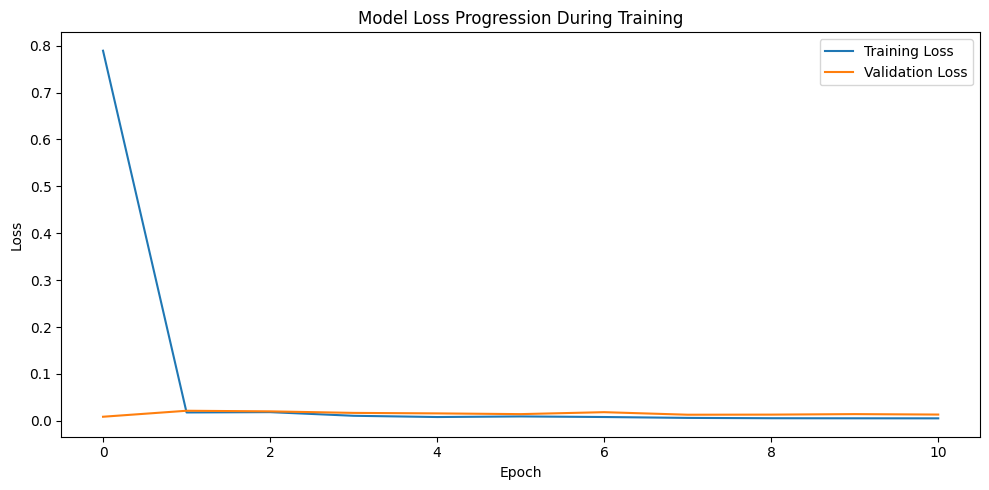

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
tft_model.eval()
test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for i in range(0, len(X_test)- sequence_length, sequence_length):
        X_batch = X_test_tensor[i:i + sequence_length].to(device)
        y_batch = y_test_tensor[i:i + sequence_length].to(device)
        outputs = tft_model(X_batch)
        loss = criterion(outputs, y_batch)
        if torch.isnan(loss):
            continue
        test_loss += loss.item() * X_batch.size(0)

        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

all_predictions_inv = sales_scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
all_targets_inv = sales_scaler.inverse_transform(np.array(all_targets).reshape(-1, 1))


Test Loss: 0.0121


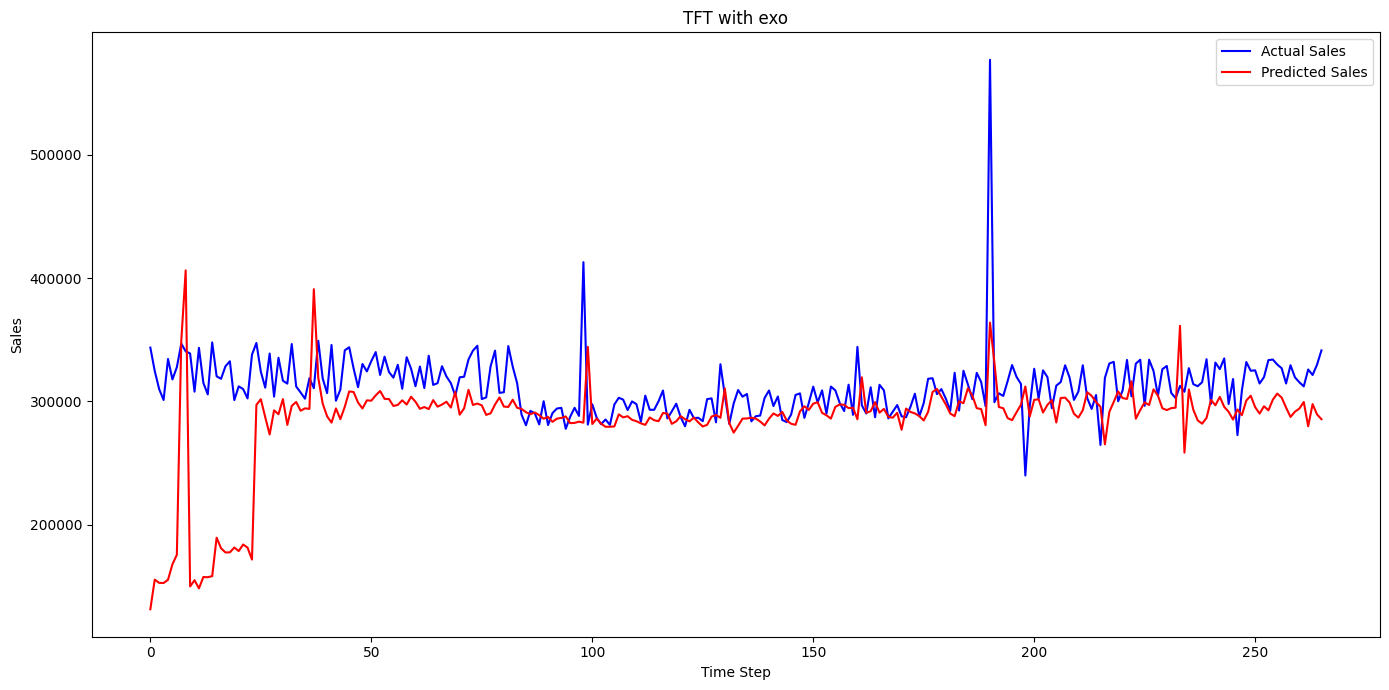

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(all_targets_inv, label='Actual Sales', color='b')
plt.plot(all_predictions_inv, label='Predicted Sales', color='r')
plt.title('TFT with exo')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
import sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# Calculate MAE, MAPE, MSE, and R2
mae = mean_absolute_error(all_targets_inv, all_predictions_inv)
mape = mean_absolute_percentage_error(all_targets_inv, all_predictions_inv)
mse = mean_squared_error(all_targets_inv, all_predictions_inv)
r2 = r2_score(all_targets_inv, all_predictions_inv)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

MAE: 32568.7148
MSE: 2894905344.0000
MAPE: 0.1004
R2: -3.5708


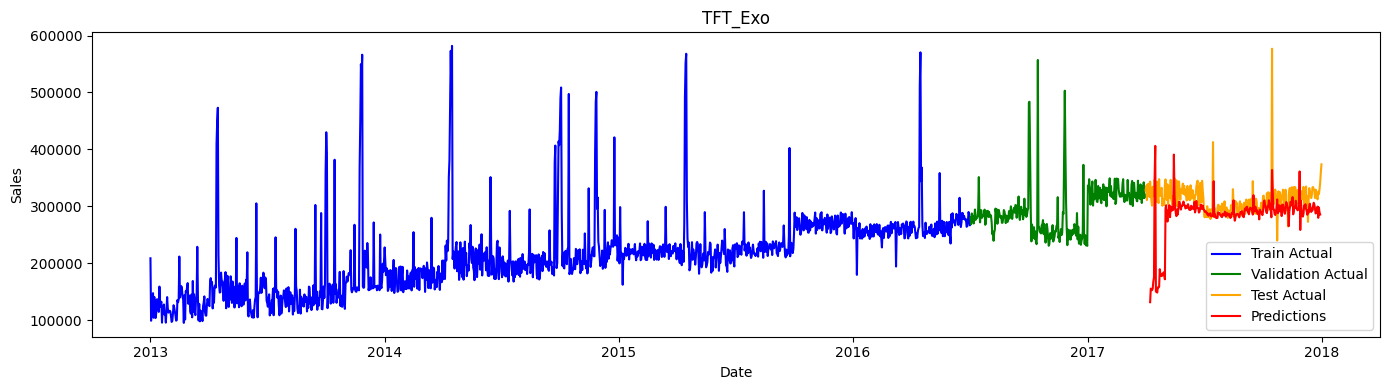

In [14]:
import matplotlib.pyplot as plt

# Combine train, val, and test indices for plotting
train_indices = train.index
val_indices = val.index
test_indices = test.index

# Plot the actual sales data for train, validation, and test sets
plt.figure(figsize=(14, 4))
plt.plot(train_indices, train['sales'], label='Train Actual', color='blue')
plt.plot(val_indices, val['sales'], label='Validation Actual', color='green')
plt.plot(test_indices, test['sales'], label='Test Actual', color='orange')

# Dates corresponding to the predictions
prediction_dates = test_indices[sequence_length:]

# Ensure that prediction_dates aligns with all_predictions_inv
prediction_dates = prediction_dates[:len(all_predictions_inv)]

# Plot the model's predictions over the test set
plt.plot(prediction_dates, all_predictions_inv, label='Predictions', color='red')



plt.title('TFT_Exo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()
